In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import community as community_louvain
from utils import correlation_matrix, distance_matrix, mst_from_distance, metrics
from community_tools import louvain_partition, plot_partition, save_partition, partition_similarity
import random
import json
import pathlib

In [7]:
# Load your data here (assuming you already have it in 'returns')
# This is just an example:
returns = pd.read_csv("data/returns.csv", index_col=0, parse_dates=True)

In [8]:
# Plot community partition (as already defined in your script)
def plot_community_partition(mst: nx.Graph, partition: dict, output_path: pathlib.Path):
    plot_partition(mst, partition, output_path)
    
    
    
# Save community partition to JSON (as already defined in your script)
def save_community_partition(partition: dict, output_path: pathlib.Path):
    save_partition(partition, output_path)

In [9]:
# Define your rolling window length and step
L, H = 252, 21  # for example, 100-day window, 20-day step

# Create paths to save the community results
OUT_COMM = pathlib.Path("communities")
OUT_COMM.mkdir(parents=True, exist_ok=True)

# Initialize list to store community data (for each time window)
community_data = []

# Loop over rolling windows
for end in range(L, len(returns), H):
    date = returns.index[end-1]
    date_str = date.strftime("%Y-%m-%d")

    # Extract the window of returns
    win = returns.iloc[end-L:end]
    win = win.loc[:, win.var(0) > 1e-6]  # filter out assets with low variance
    if win.shape[1] < 2:
        continue  # skip if not enough assets

    # Compute correlation and distance matrix
    C = correlation_matrix(win)
    D = distance_matrix(C)

    # Generate Minimum Spanning Tree
    mst = mst_from_distance(D)
    for _, _, d in mst.edges(data=True):
        d["weight"] = 1.0 / (d["weight"] + 1e-9)

    # Perform community detection using Louvain method
    local_partition = louvain_partition(mst)

    # Save community partition and plot
    save_community_partition(local_partition, OUT_COMM / f"{date_str}.json")
    plot_community_partition(mst, local_partition, OUT_COMM / f"{date_str}.png")
    
    # Optionally, save additional community information
    community_data.append({
        'date': date_str,
        'community_membership': local_partition,

        'num_communities': len(set(local_partition.values())),
        'community_sizes': {cid: len([n for n, c in local_partition.items() if c == cid]) for cid in set(local_partition.values())}
    })

In [10]:
# Save community data to a CSV file or JSON for analysis
community_df = pd.DataFrame(community_data)
community_df.to_csv(OUT_COMM / "community_memberships.csv", index=False)

# Optionally, save it as a JSON for more detailed analysis
with open(OUT_COMM / "community_memberships.json", "w") as f:
    json.dump(community_data, f, indent=2)

<Figure size 1000x600 with 0 Axes>

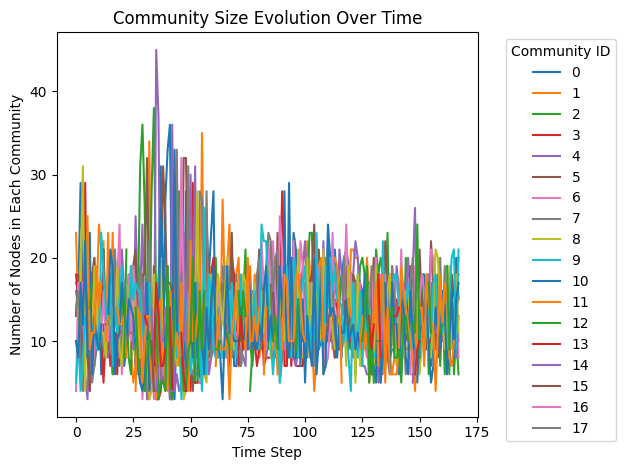

In [11]:
# Plot the evolution of community sizes over time
community_sizes_over_time = []
for entry in community_data:
    community_sizes_over_time.append(entry['community_sizes'])

community_sizes_df = pd.DataFrame(community_sizes_over_time)

# You can now plot this to see how community sizes evolve
plt.figure(figsize=(10, 6))
community_sizes_df.plot(kind='line', title='Community Size Evolution Over Time')
plt.xlabel('Time Step')
plt.ylabel('Number of Nodes in Each Community')
plt.legend(title='Community ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(OUT_COMM / "community_size_evolution.png")

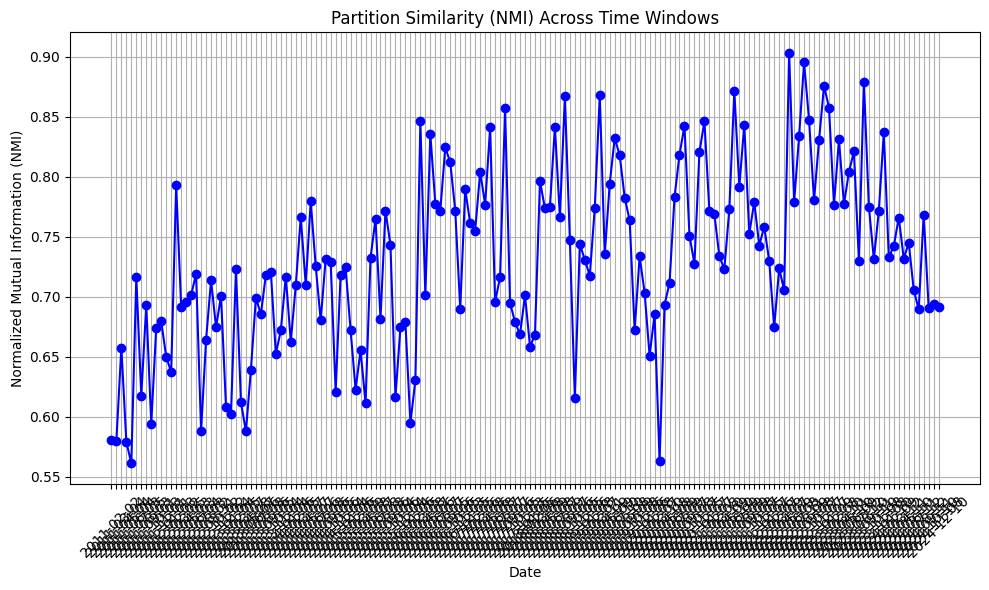

In [12]:
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.pyplot as plt

# Function to compute NMI between two community partitions
def compute_nmi(partition1, partition2):
    # Ensure the partitions are aligned by asset names
    common_assets = set(partition1.keys()).intersection(set(partition2.keys()))
    
    if len(common_assets) == 0:
        return 0  # No common assets to compare
    
    # Extract the community labels for common assets
    labels1 = [partition1[asset] for asset in common_assets]
    labels2 = [partition2[asset] for asset in common_assets]
    
    # Compute normalized mutual information between the two partitions
    return normalized_mutual_info_score(labels1, labels2)

# Initialize a list to store the NMI values
nmi_values = []

# Loop over pairs of consecutive time windows
for i in range(1, len(community_df)):
    partition1 = community_df['community_membership'].iloc[i-1]
    partition2 = community_df['community_membership'].iloc[i]
    
    # Compute NMI between the consecutive partitions
    nmi = compute_nmi(partition1, partition2)
    
    # Append the NMI value to the list
    nmi_values.append(nmi)

# Plot the NMI values over time
plt.figure(figsize=(10, 6))
plt.plot(community_df['date'].iloc[1:], nmi_values, marker='o', linestyle='-', color='b')
plt.title('Partition Similarity (NMI) Across Time Windows')
plt.xlabel('Date')
plt.ylabel('Normalized Mutual Information (NMI)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


14028it [00:00, 17310.61it/s]


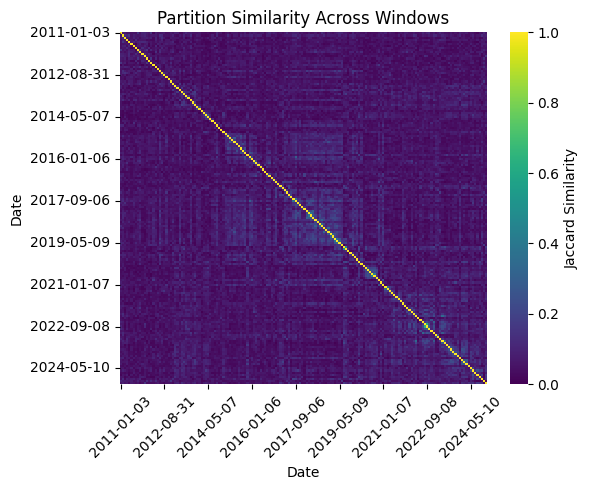

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm import tqdm  # For progress bar

# Function to compute the Jaccard similarity between two sets of community memberships
def jaccard(a, b):
    return len(a & b) / len(a | b) if a or b else 1.0

# Initialize the list to store partition data
partitions = community_df['community_membership']

# Create an index for the partitions (based on date)
idx = community_df['date']

# Initialize a DataFrame to store pairwise similarity values
sim = pd.DataFrame(index=idx, columns=idx, dtype=float)

# Compute pairwise Jaccard similarity between all time window pairs
for i, j in tqdm(combinations(range(len(idx)), 2)):
    pi, pj = partitions.iloc[i], partitions.iloc[j]
    
    # Find the common nodes (assets) between two partitions
    nodes = set(pi.keys()) & set(pj.keys())
    
    if not nodes:
        v = 0.0  # If there are no common nodes, similarity is 0
    else:
        # Flatten the community sets and compute Jaccard similarity
        v = jaccard(set((pi[k], k) for k in nodes), set((pj[k], k) for k in nodes))
    
    # Store the computed similarity in the similarity matrix
    sim.iat[i, j] = sim.iat[j, i] = v

# Set the diagonal values to 1 (self-similarity)
np.fill_diagonal(sim.values, 1.0)

# Plot the Jaccard similarity matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(sim, cmap='viridis', cbar_kws={'label': 'Jaccard Similarity'}, xticklabels=20, yticklabels=20)
plt.title('Partition Similarity Across Windows')
plt.xlabel('Date')
plt.ylabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Load the S&P 500 company info file
company_df = pd.read_csv("data/sp500_companies.csv")

In [15]:
partitions = pd.Series(partitions).sort_index()

In [16]:
partitions = pd.Series(partitions, name="partition")
partitions.index = pd.to_datetime(partitions.index)  # enforce datetime index
partitions = partitions.sort_index()

In [17]:
years = sorted(set(partitions.index.year))

In [18]:
# Map each company to its sector for easy lookup
sector_map = company_df.set_index('Symbol')['Sector'].to_dict()

# Function to calculate sector composition for each community in a given time window
def calculate_sector_composition(partition, sector_map):
    # Initialize a dictionary to store sector counts for each community
    community_sector_composition = {}

    for stock, community_id in partition.items():
        sector = sector_map.get(stock)
        if sector:  # Only include stocks with valid sectors
            if community_id not in community_sector_composition:
                community_sector_composition[community_id] = {}
            if sector not in community_sector_composition[community_id]:
                community_sector_composition[community_id][sector] = 0
            community_sector_composition[community_id][sector] += 1
    
    return community_sector_composition

In [19]:
# Initialize list to store sector composition data
sector_compositions = []

# Loop over each time window to calculate sector composition
for date, partition in partitions.items():
    # Calculate the sector composition for this partition
    sector_composition = calculate_sector_composition(partition, sector_map)
    
    # Convert the sector composition into a DataFrame for easier plotting
    df = pd.DataFrame.from_dict(sector_composition, orient='index').fillna(0)
    df['date'] = date
    
    # Reset index to get community_id as a column and set MultiIndex
    df = df.reset_index().rename(columns={'index': 'community_id'})
    df = df.set_index(['community_id', 'date'])
    
    sector_compositions.append(df)

# Combine the sector compositions across all time windows into a single DataFrame
sector_compositions_df = pd.concat(sector_compositions)
sector_compositions_df.head()

,,Healthcare,Consumer Defensive,Energy,Technology,Communication Services,Utilities,Basic Materials,Consumer Cyclical,Industrials,Real Estate,Financial Services
community_id,date,,,,,,,,,,,
0,1970-01-01,6.0,8.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1970-01-01,5.0,2.0,4.0,1.0,0.0,1.0,3.0,4.0,2.0,1.0,0.0
3,1970-01-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,15.0
5,1970-01-01,1.0,0.0,0.0,0.0,1.0,0.0,4.0,2.0,1.0,1.0,3.0
7,1970-01-01,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,6.0,1.0,1.0


In [121]:
# import matplotlib.pyplot as plt

# # Loop through each community and plot sector composition over time
# for community_id in sector_compositions_df.index.get_level_values('community_id').unique():
#     # Extract data for the specific community
#     community_data = sector_compositions_df.xs(community_id, level='community_id', drop_level=False)
    
#     # Plot sector composition without dropping 'date' index
#     ax = community_data.plot(kind='bar', stacked=True, figsize=(12, 8), title=f"Sector Composition for Community {community_id}")
    
#     # Set labels and title
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Number of Stocks')
    
#     # Set x-axis labels to show the date in a readable format (e.g., 'Jan-2011', 'Feb-2011')
#     ax.set_xticklabels(community_data.index.get_level_values('date').strftime('%b-%Y'), rotation=45)
    
#     plt.tight_layout()
#     plt.show()


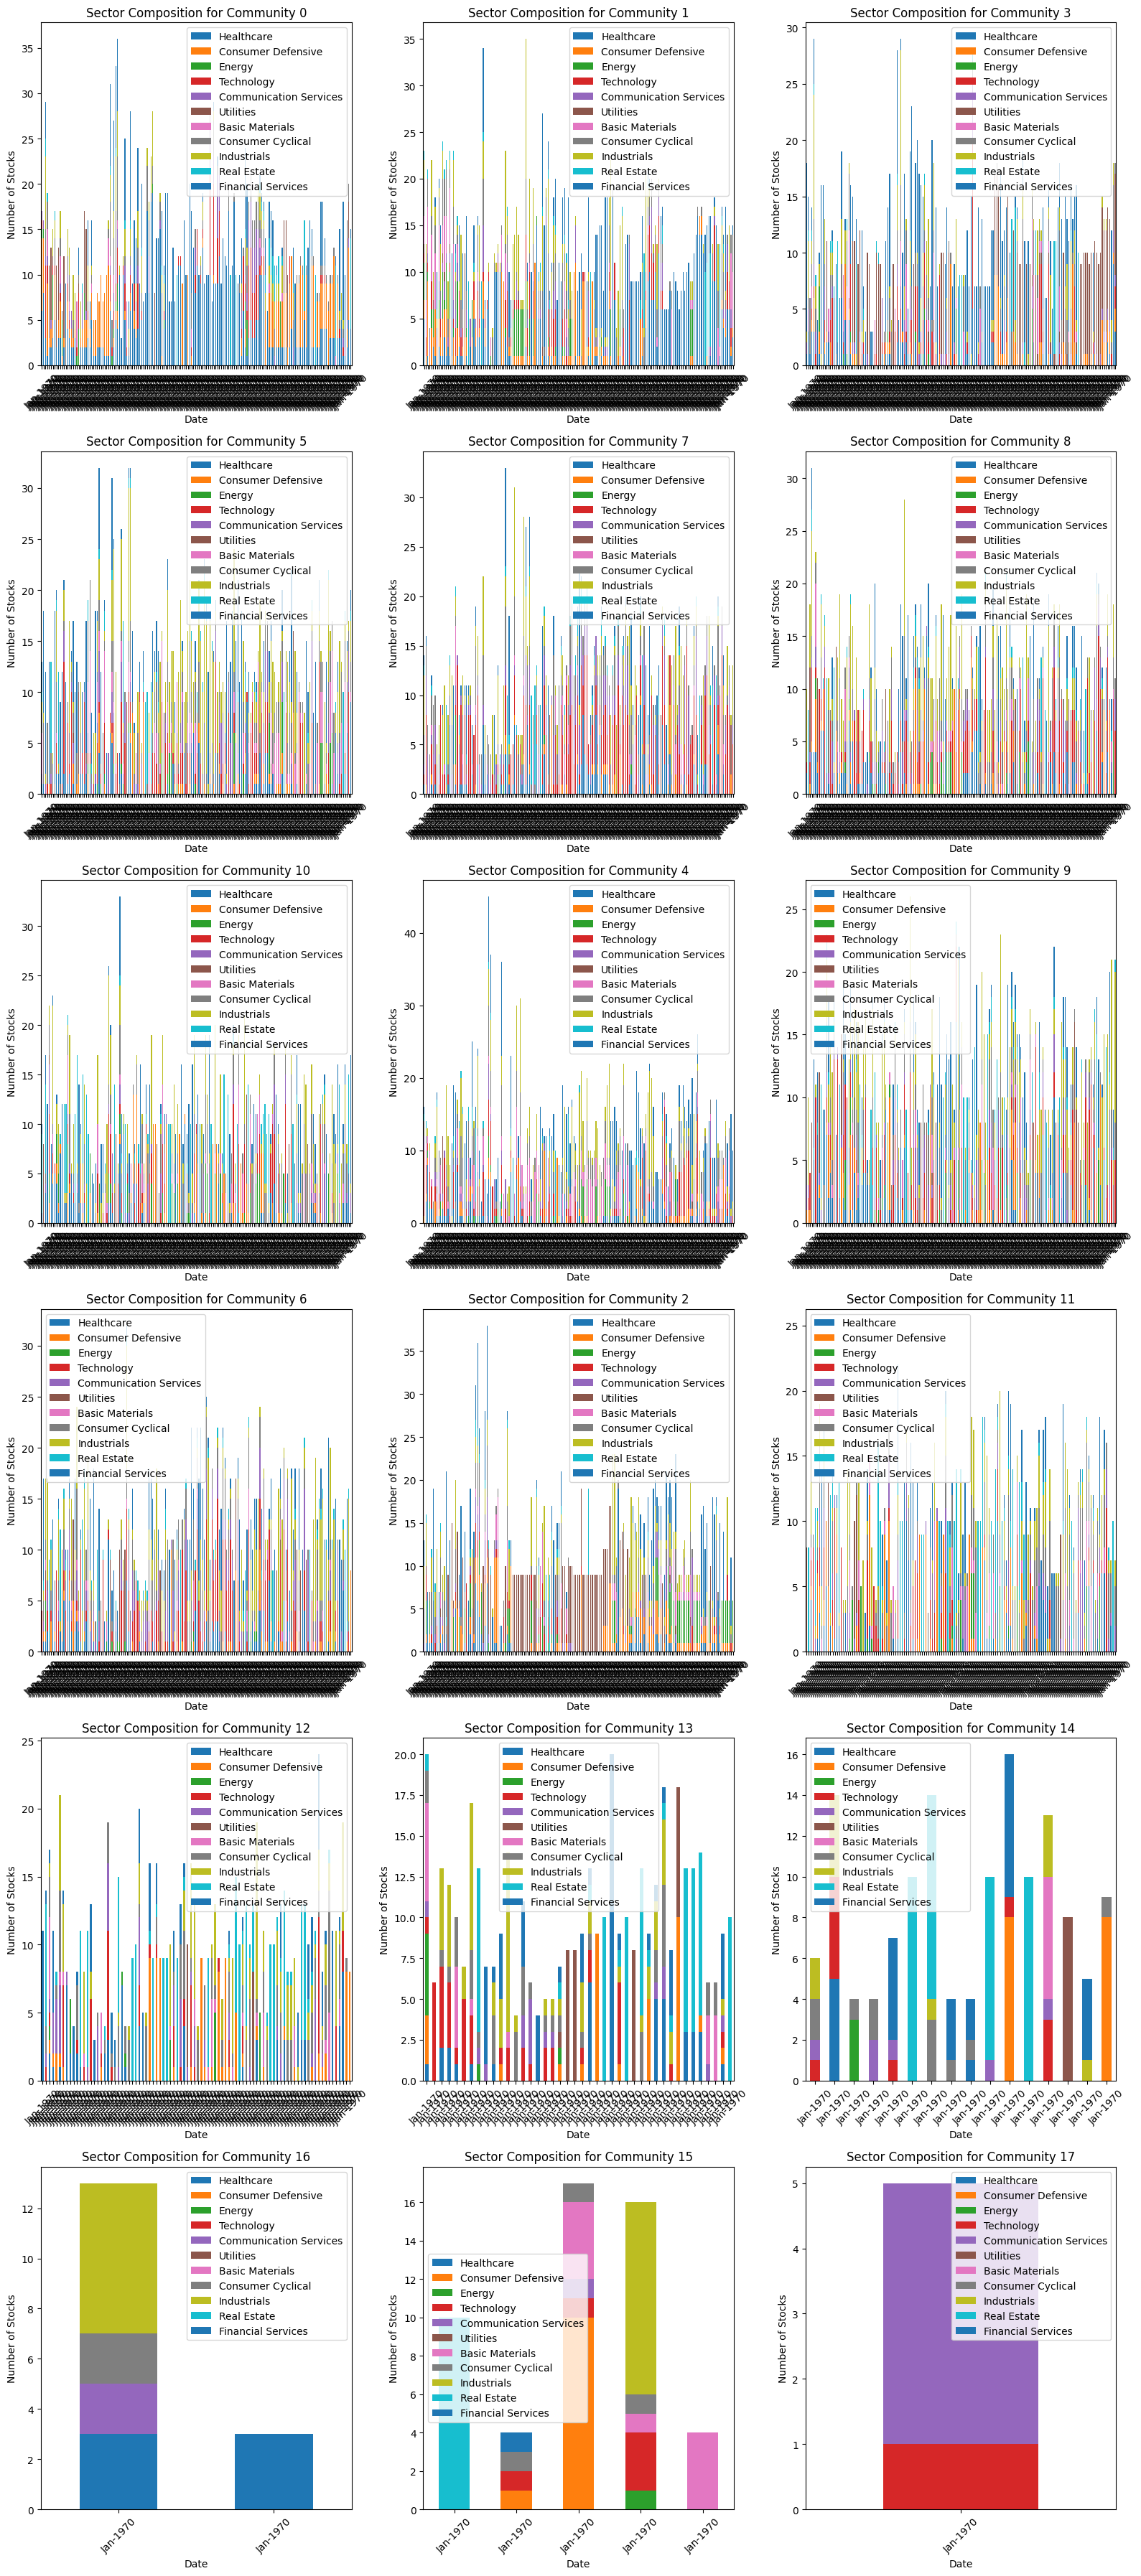

In [20]:
import matplotlib.pyplot as plt

# Get the number of communities
num_communities = len(sector_compositions_df.index.get_level_values('community_id').unique())

# Define the number of rows and columns for the subplots (e.g., a grid with multiple rows and columns)
# Adjust this based on the number of communities and your preferences for the layout
ncols = 3  # Number of columns for subplots
nrows = (num_communities + ncols - 1) // ncols  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6 * nrows))

# Flatten the axes array for easier iteration if the layout is 2D
axes = axes.flatten()

# Loop through each community and plot sector composition over time
for i, community_id in enumerate(sector_compositions_df.index.get_level_values('community_id').unique()):
    # Extract data for the specific community
    community_data = sector_compositions_df.xs(community_id, level='community_id', drop_level=False)
    
    # Plot sector composition without dropping 'date' index in the appropriate subplot
    ax = axes[i]
    community_data.plot(kind='bar', stacked=True, ax=ax, title=f"Sector Composition for Community {community_id}")
    
    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Stocks')
    
    # Set x-axis labels to show the date in a readable format (e.g., 'Jan-2011', 'Feb-2011')
    ax.set_xticklabels(community_data.index.get_level_values('date').strftime('%b-%Y'), rotation=45)

# Remove any unused axes (in case the number of communities is not a perfect multiple of ncols)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [21]:
from scipy.stats import entropy
import pandas as pd
from collections import defaultdict

# Function to calculate community sector entropy
def community_sector_entropy(partition, sector_map):
    cid_sectors = defaultdict(list)
    for stock, cid in partition.items():
        sec = sector_map.get(stock.upper(), "Unknown")
        cid_sectors[cid].append(sec)
    
    return {cid: entropy(pd.Series(secs).value_counts(normalize=True)) 
            for cid, secs in cid_sectors.items()}

# Assuming `partitions` is a pandas DataFrame or Series indexed by time
# `sector_map` is a dictionary mapping stock symbols to sectors
t = partitions.index[0]  # First timestamp in the data
entropy_dict = community_sector_entropy(partitions[t], sector_map)

# Convert the result into a sorted pandas Series for easy viewing
entropy_series = pd.Series(entropy_dict).sort_index()

entropy_series

0     1.222267
1     2.039582
2     1.265857
3     0.633663
4     1.363363
5     1.778233
6     0.000000
7     1.635743
8     0.801819
9     1.054920
10    0.639032
11    0.000000
dtype: float64

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# Load the community membership CSV
community_df = pd.read_csv("/Users/soniaborsi/Desktop/Financial-Network-Analysis/communities/community_memberships.csv")

# Parse the community_membership column (which is a string of dictionaries)
community_df['community_membership'] = community_df['community_membership'].apply(ast.literal_eval)

# Get all the tickers (stock symbols) and dates
tickers = sorted(set(ticker for community in community_df['community_membership'] for ticker in community.keys()))
tickers

['ABBV',
 'ABT',
 'ADM',
 'AES',
 'AJG',
 'ALB',
 'ALL',
 'ALLE',
 'AMP',
 'AMZN',
 'ANET',
 'ANSS',
 'AOS',
 'APH',
 'AXON',
 'AXP',
 'BAX',
 'BBY',
 'BDX',
 'BEN',
 'BK',
 'BKR',
 'BLDR',
 'BRO',
 'BSX',
 'BWA',
 'C',
 'CAT',
 'CCL',
 'CE',
 'CLX',
 'CMCSA',
 'CME',
 'COF',
 'CRM',
 'CSCO',
 'CSGP',
 'CVX',
 'DE',
 'DFS',
 'DG',
 'DHI',
 'DIS',
 'DLR',
 'DOV',
 'DPZ',
 'DTE',
 'DXCM',
 'EA',
 'ED',
 'EFX',
 'EIX',
 'EL',
 'EMN',
 'ENPH',
 'EQIX',
 'EQR',
 'EQT',
 'ESS',
 'EXPE',
 'FAST',
 'FCX',
 'FDS',
 'FDX',
 'FFIV',
 'FRT',
 'FSLR',
 'FTNT',
 'GIS',
 'GLW',
 'GOOG',
 'GPN',
 'HCA',
 'HIG',
 'HII',
 'HLT',
 'HRL',
 'HSIC',
 'HST',
 'ICE',
 'IEX',
 'IFF',
 'INCY',
 'IP',
 'IQV',
 'IRM',
 'ISRG',
 'JBHT',
 'JCI',
 'K',
 'KIM',
 'KMX',
 'LEN',
 'LH',
 'LKQ',
 'LRCX',
 'MCD',
 'META',
 'MO',
 'MRK',
 'MSFT',
 'MSI',
 'MTD',
 'NDAQ',
 'NFLX',
 'NTAP',
 'NVDA',
 'O',
 'OMC',
 'ON',
 'ORCL',
 'PARA',
 'PAYX',
 'PEG',
 'PEP',
 'PFG',
 'PGR',
 'PH',
 'PHM',
 'PKG',
 'PM',
 'PNC',
 'PNW',
 

In [23]:
community_df

,date,community_membership,num_communities,community_sizes
0,2011-01-03,"{'ABT': 0, 'ADM': 0, 'AES': 1, 'AJG': 2, 'ALB'...",12,"{0: 17, 1: 23, 2: 13, 3: 18, 4: 16, 5: 13, 6: ..."
1,2011-02-02,"{'ABT': 0, 'ADM': 1, 'AES': 2, 'AJG': 3, 'ALB'...",11,"{0: 16, 1: 13, 2: 16, 3: 15, 4: 14, 5: 18, 6: ..."
2,2011-03-04,"{'ABT': 1, 'ADM': 1, 'AES': 6, 'AJG': 0, 'ALB'...",11,"{0: 29, 1: 21, 2: 7, 3: 6, 4: 13, 5: 12, 6: 17..."
3,2011-04-04,"{'ABT': 2, 'ADM': 0, 'AES': 2, 'AJG': 8, 'ALB'...",13,"{0: 19, 1: 4, 2: 7, 3: 14, 4: 11, 5: 7, 6: 17,..."
4,2011-05-04,"{'ABT': 0, 'ADM': 1, 'AES': 10, 'AJG': 3, 'ALB...",11,"{0: 11, 1: 22, 2: 12, 3: 29, 4: 6, 5: 13, 6: 9..."
...,...,...,...,...
163,2024-08-12,"{'ABBV': 0, 'ABT': 1, 'ADM': 2, 'AES': 3, 'AJG...",13,"{0: 18, 1: 17, 2: 6, 3: 14, 4: 14, 5: 10, 6: 1..."
164,2024-09-11,"{'ABBV': 0, 'ABT': 1, 'ADM': 2, 'AES': 3, 'AJG...",12,"{0: 10, 1: 14, 2: 18, 3: 13, 4: 11, 5: 18, 6: ..."
165,2024-10-10,"{'ABBV': 0, 'ABT': 1, 'ADM': 2, 'AES': 0, 'AJG...",13,"{0: 16, 1: 15, 2: 6, 3: 12, 4: 13, 5: 15, 6: 1..."
166,2024-11-08,"{'ABBV': 0, 'ABT': 0, 'ADM': 1, 'AES': 0, 'AJG...",11,"{0: 20, 1: 14, 2: 11, 3: 18, 4: 15, 5: 17, 6: ..."


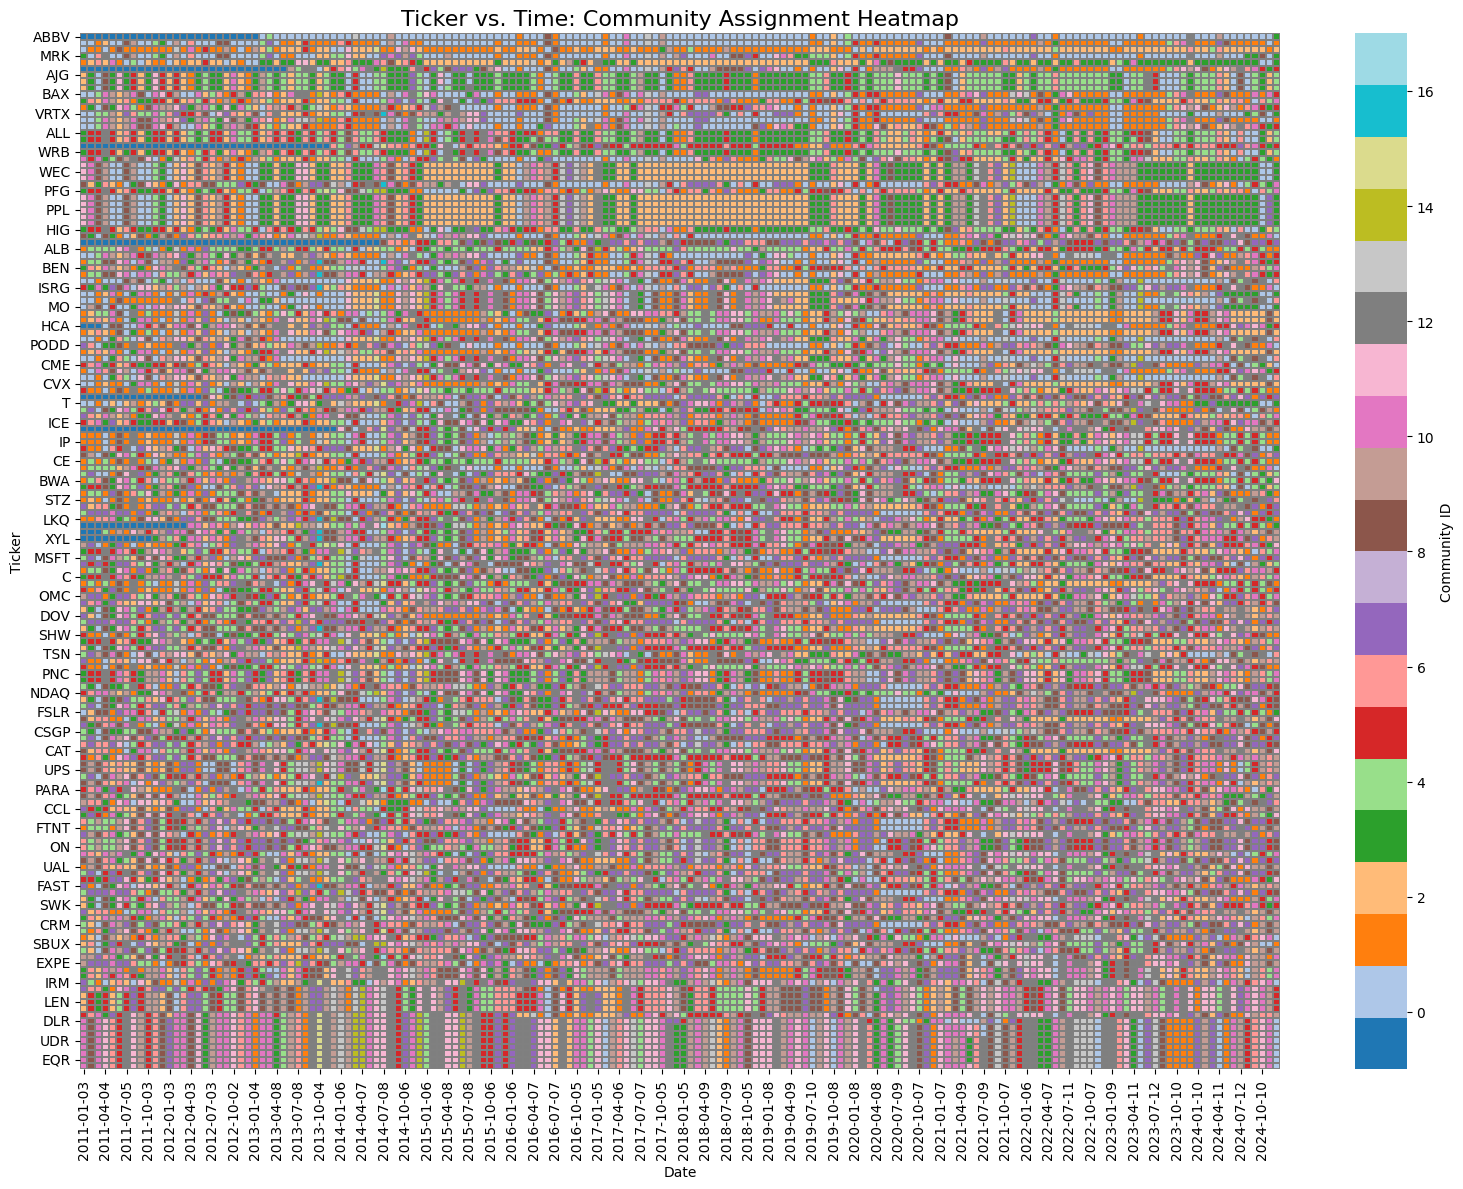

In [24]:
dates = community_df['date']

# Create an empty DataFrame with tickers as rows and dates as columns
heatmap_data = pd.DataFrame(index=tickers, columns=dates)

# Fill the DataFrame with community assignments
for idx, row in community_df.iterrows():
    date = row['date']
    community_membership = row['community_membership']
    
    # Fill in the community assignments for this date
    for stock, community_id in community_membership.items():
        heatmap_data.at[stock, date] = community_id

# Convert to numeric and fill missing values with -1 (for stocks with no community assigned)
heatmap_data = heatmap_data.astype(float).fillna(-1)

# Optional: Reorder rows by the similarity of community history (this step is based on sum of the communities assigned)
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values().index]

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(
    heatmap_data,
    cmap="tab20",  # distinct colors per community
    cbar_kws={'label': 'Community ID'},
    linewidths=0.1,
    linecolor='gray'
)

plt.title("Ticker vs. Time: Community Assignment Heatmap", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Ticker")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [25]:
import pandas as pd

# Calculate the persistence of each stock's community membership over time
def calculate_persistence(heatmap_data):
    persistence_values = {}

    # Iterate over each stock in the heatmap data
    for stock in heatmap_data.index:
        community_history = heatmap_data.loc[stock].values
        total_periods = len(community_history)
        
        if total_periods == 0:
            continue
        
        # Calculate the number of periods where the stock remains in the same community
        same_community_count = 1  # count the first community assignment as a start
        for i in range(1, total_periods):
            if community_history[i] == community_history[i-1]:
                same_community_count += 1

        # Calculate persistence as the proportion of time in the same community
        persistence = same_community_count / total_periods
        persistence_values[stock] = persistence

    # Convert the persistence dictionary into a pandas Series for easy sorting
    persistence_df = pd.Series(persistence_values).sort_values(ascending=False)

    return persistence_df

# Assuming heatmap_data is the DataFrame with stocks as rows, dates as columns, and community IDs as values
# Compute the persistence values
persistence_df = calculate_persistence(heatmap_data)

# Display the stocks with the highest persistence
persistence_df.head(10)


ABBV    0.755952
ABT     0.547619
ADM     0.541667
AES     0.482143
ALLE    0.458333
MRK     0.458333
ED      0.434524
WEC     0.434524
DTE     0.434524
SO      0.428571
dtype: float64

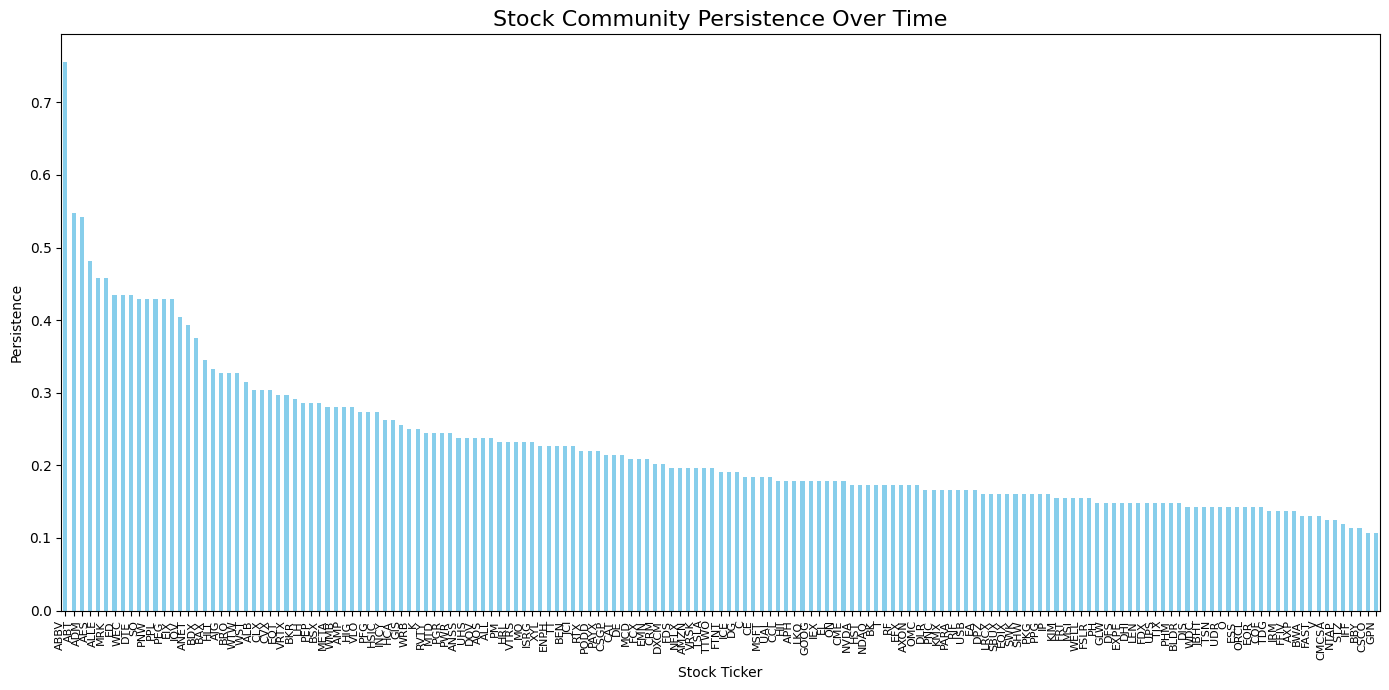

In [26]:
plt.figure(figsize=(14, 7))
persistence_df.plot(kind='bar', color='skyblue', legend=False)
plt.title('Stock Community Persistence Over Time', fontsize=16)
plt.xlabel('Stock Ticker')
plt.ylabel('Persistence')
plt.xticks(rotation=90, ha='right', fontsize=8)  # Rotate and shrink
plt.tight_layout()
plt.show()


In [27]:

# Step 3: Merge persistence_df (top 10 stocks by persistence) with company sector data
# Merge the top 10 stocks with the company information to get their sector
top_10_stocks = persistence_df.head(30).index
top_10_stocks_info = company_df[company_df['Symbol'].isin(top_10_stocks)][['Symbol', 'Sector']]

# Merge the persistence values with sector information
top_10_stocks_info['Persistence'] = persistence_df.head(30).values

# Step 4: Analyze the persistence of stocks by sector
sector_persistence = top_10_stocks_info.groupby('Sector')['Persistence'].mean()

# Step 5: Display the results (stocks with high persistence and their sectors)
print("Top 10 stocks by persistence and their sectors:")
print(top_10_stocks_info)

# Step 6: Display average persistence by sector
print("\nAverage persistence by sector:")
print(sector_persistence)

Top 10 stocks by persistence and their sectors:
    Symbol              Sector  Persistence
25    ABBV          Healthcare     0.755952
28     CVX              Energy     0.547619
29     MRK          Healthcare     0.541667
43     ABT          Healthcare     0.482143
66    ANET          Technology     0.458333
95    VRTX          Healthcare     0.458333
102     SO           Utilities     0.434524
143    AJG  Financial Services     0.434524
152    BDX          Healthcare     0.434524
161    HLT   Consumer Cyclical     0.428571
222    PEG           Utilities     0.428571
229    BKR              Energy     0.428571
254    IQV          Healthcare     0.428571
271    WTW  Financial Services     0.428571
278     ED           Utilities     0.404762
282    EIX           Utilities     0.392857
286    WEC           Utilities     0.375000
290    BRO  Financial Services     0.345238
320    EQT              Energy     0.333333
323    DTE           Utilities     0.327381
326    ADM  Consumer Defensi

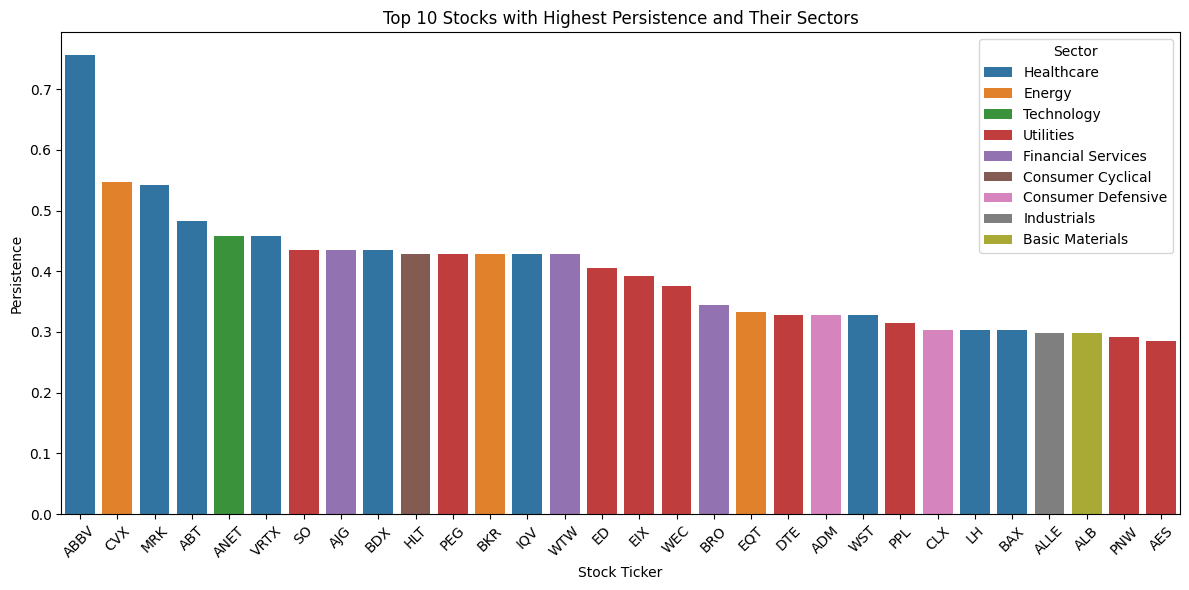

In [28]:
# Plot persistence for the top 10 stocks and their sectors
plt.figure(figsize=(12, 6))
sns.barplot(x='Symbol', y='Persistence', data=top_10_stocks_info, hue='Sector')
plt.title("Top 10 Stocks with Highest Persistence and Their Sectors")
plt.xlabel("Stock Ticker")
plt.ylabel("Persistence")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


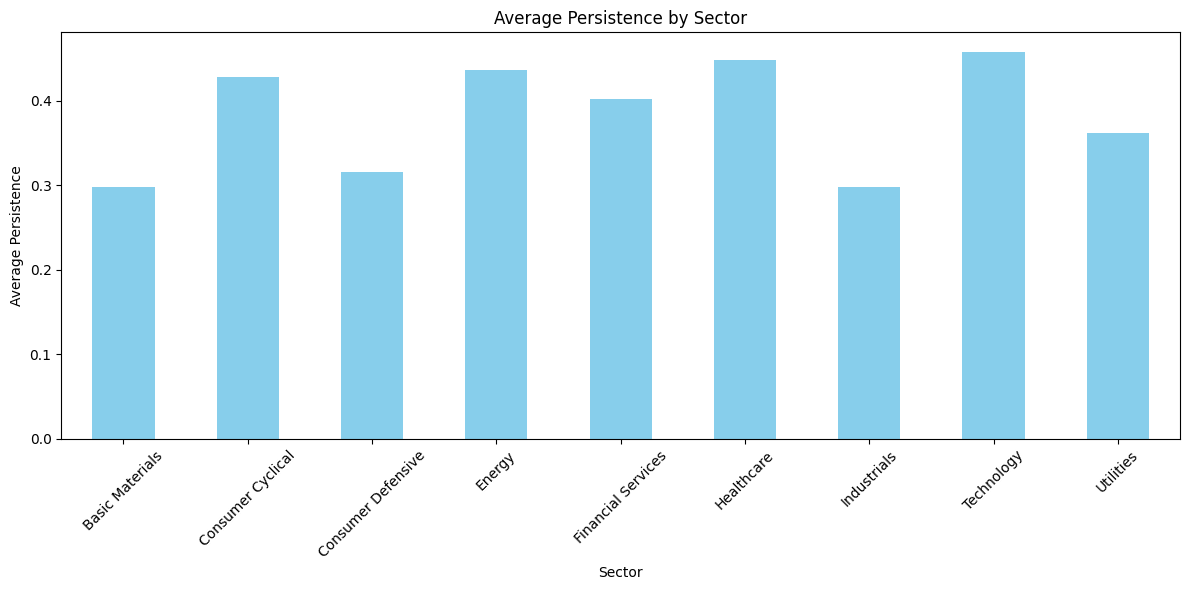

In [29]:

# Optional: Plot average persistence by sector
plt.figure(figsize=(12, 6))
sector_persistence.plot(kind='bar', color='skyblue')
plt.title("Average Persistence by Sector")
plt.xlabel("Sector")
plt.ylabel("Average Persistence")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:

# Calculate the persistence of each stock's community membership over time
def calculate_persistence(heatmap_data):
    persistence_values = {}

    # Iterate over each stock in the heatmap data
    for stock in heatmap_data.index:
        community_history = heatmap_data.loc[stock].values
        total_periods = len(community_history)
        
        if total_periods == 0:
            continue
        
        # Calculate the number of periods where the stock remains in the same community
        same_community_count = 1  # count the first community assignment as a start
        for i in range(1, total_periods):
            if community_history[i] == community_history[i-1]:
                same_community_count += 1

        # Calculate persistence as the proportion of time in the same community
        persistence = same_community_count / total_periods
        persistence_values[stock] = persistence

    # Convert the persistence dictionary into a pandas Series for easy sorting
    persistence_df = pd.Series(persistence_values).sort_values(ascending=False)

    return persistence_df

# Assuming heatmap_data is the DataFrame with stocks as rows, dates as columns, and community IDs as values
# Compute the persistence values
persistence_df = calculate_persistence(heatmap_data)

# Display the stocks with the highest persistence
persistence_df.head(10)


ABBV    0.755952
ABT     0.547619
ADM     0.541667
AES     0.482143
ALLE    0.458333
MRK     0.458333
ED      0.434524
WEC     0.434524
DTE     0.434524
SO      0.428571
dtype: float64

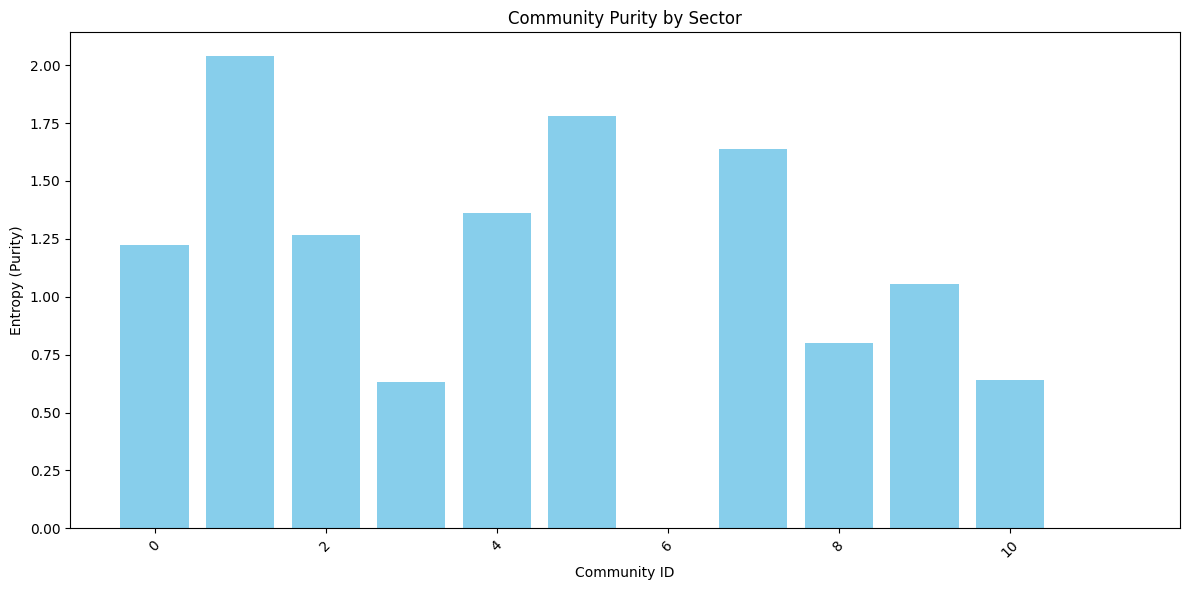

In [31]:

def calculate_sector_purity(community_data, sector_map):
    cid_sectors = defaultdict(list)
    for stock, community_id in community_data.items():
        sector = sector_map.get(stock, "Unknown")
        cid_sectors[community_id].append(sector)
    
    purity_values = {}
    for community_id, sectors in cid_sectors.items():
        sector_counts = pd.Series(sectors).value_counts(normalize=True)
        purity_values[community_id] = entropy(sector_counts)
    
    return purity_values

# Example: Calculate sector purity for the first date's community assignment
first_date_community_data = community_df['community_membership'][0]  # Assuming it's the first row
sector_purity = calculate_sector_purity(first_date_community_data, sector_map)

# Visualize the sector purity by community
plt.figure(figsize=(12, 6))
plt.bar(sector_purity.keys(), sector_purity.values(), color='skyblue')
plt.title('Community Purity by Sector')
plt.xlabel('Community ID')
plt.ylabel('Entropy (Purity)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [32]:
community_df

,date,community_membership,num_communities,community_sizes
0,2011-01-03,"{'ABT': 0, 'ADM': 0, 'AES': 1, 'AJG': 2, 'ALB'...",12,"{0: 17, 1: 23, 2: 13, 3: 18, 4: 16, 5: 13, 6: ..."
1,2011-02-02,"{'ABT': 0, 'ADM': 1, 'AES': 2, 'AJG': 3, 'ALB'...",11,"{0: 16, 1: 13, 2: 16, 3: 15, 4: 14, 5: 18, 6: ..."
2,2011-03-04,"{'ABT': 1, 'ADM': 1, 'AES': 6, 'AJG': 0, 'ALB'...",11,"{0: 29, 1: 21, 2: 7, 3: 6, 4: 13, 5: 12, 6: 17..."
3,2011-04-04,"{'ABT': 2, 'ADM': 0, 'AES': 2, 'AJG': 8, 'ALB'...",13,"{0: 19, 1: 4, 2: 7, 3: 14, 4: 11, 5: 7, 6: 17,..."
4,2011-05-04,"{'ABT': 0, 'ADM': 1, 'AES': 10, 'AJG': 3, 'ALB...",11,"{0: 11, 1: 22, 2: 12, 3: 29, 4: 6, 5: 13, 6: 9..."
...,...,...,...,...
163,2024-08-12,"{'ABBV': 0, 'ABT': 1, 'ADM': 2, 'AES': 3, 'AJG...",13,"{0: 18, 1: 17, 2: 6, 3: 14, 4: 14, 5: 10, 6: 1..."
164,2024-09-11,"{'ABBV': 0, 'ABT': 1, 'ADM': 2, 'AES': 3, 'AJG...",12,"{0: 10, 1: 14, 2: 18, 3: 13, 4: 11, 5: 18, 6: ..."
165,2024-10-10,"{'ABBV': 0, 'ABT': 1, 'ADM': 2, 'AES': 0, 'AJG...",13,"{0: 16, 1: 15, 2: 6, 3: 12, 4: 13, 5: 15, 6: 1..."
166,2024-11-08,"{'ABBV': 0, 'ABT': 0, 'ADM': 1, 'AES': 0, 'AJG...",11,"{0: 20, 1: 14, 2: 11, 3: 18, 4: 15, 5: 17, 6: ..."


In [34]:
def get_community_composition(community_data, sector_map, target_cids=None):
    """
    Returns a breakdown of sectors for specified community IDs.
    If target_cids is None, returns composition for all communities.
    """
    from collections import defaultdict
    community_sector_map = defaultdict(lambda: defaultdict(int))

    for stock, cid in community_data.items():
        if target_cids is None or cid in target_cids:
            sector = sector_map.get(stock, "Unknown")
            community_sector_map[cid][sector] += 1

    return dict(community_sector_map)

In [35]:
# Choose a specific time window (e.g., first)
example_communities = community_df['community_membership'][0]

# Focus on communities 1, 3, 5, 7, 10 (the ones mentioned in the plot analysis)
interesting_cids = [1, 3, 5, 7, 10]

# Get their sector breakdown
composition = get_community_composition(example_communities, sector_map, target_cids=interesting_cids)

# Pretty print
for cid, sectors in composition.items():
    print(f"\nCommunity {cid} Sector Breakdown:")
    for sector, count in sorted(sectors.items(), key=lambda x: -x[1]):
        print(f"  {sector:<25} {count}")


Community 1 Sector Breakdown:
  Healthcare                5
  Energy                    4
  Consumer Cyclical         4
  Basic Materials           3
  Industrials               2
  Consumer Defensive        2
  Utilities                 1
  Real Estate               1
  Technology                1

Community 3 Sector Breakdown:
  Financial Services        15
  Communication Services    1
  Healthcare                1
  Industrials               1

Community 5 Sector Breakdown:
  Basic Materials           4
  Financial Services        3
  Consumer Cyclical         2
  Industrials               1
  Real Estate               1
  Healthcare                1
  Communication Services    1

Community 7 Sector Breakdown:
  Industrials               6
  Consumer Cyclical         3
  Communication Services    1
  Real Estate               1
  Technology                1
  Healthcare                1
  Financial Services        1

Community 10 Sector Breakdown:
  Real Estate               8
  F

  Symbol  Persistence     Marketcap
0   ABBV     0.755952  310274424832
1    ABT     0.547619  198127370240
2    ADM     0.541667   24161183744
3    AES     0.482143    9243351040
4   ALLE     0.458333   11490313216
5    MRK     0.458333  248031199232
6     ED     0.434524   31191611392
7    WEC     0.434524   29895450624
8    DTE     0.434524   24889397248
9     SO     0.428571   90788044800


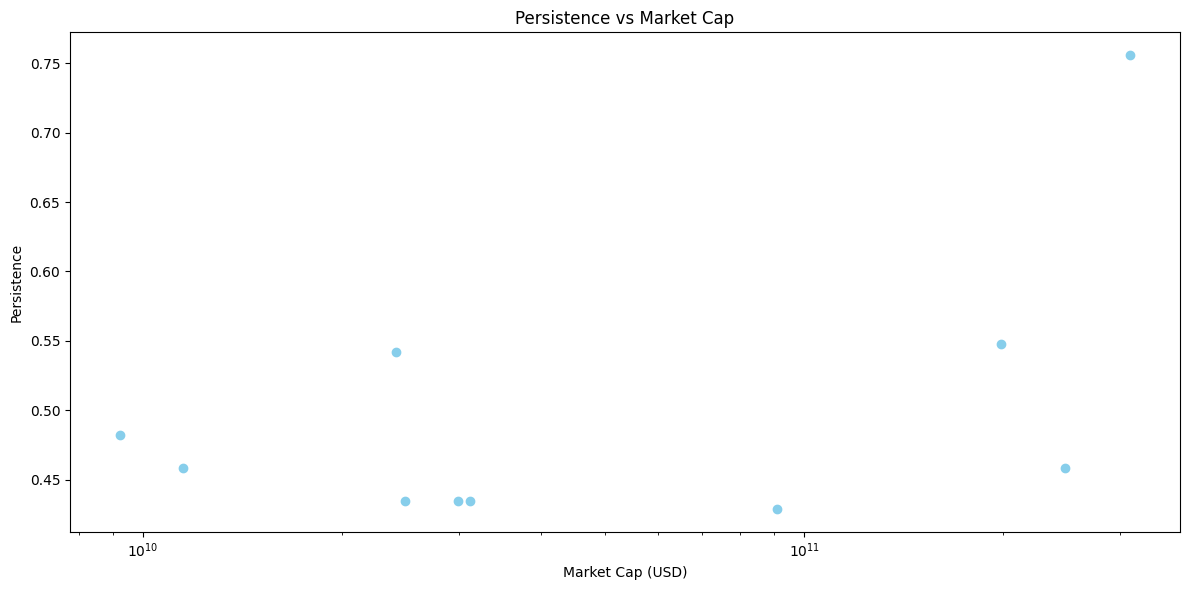

In [33]:
import pandas as pd

# Assuming persistence_df is a pandas Series with stock symbols as index and persistence values as the data

# Convert persistence_df to a DataFrame
persistence_df = persistence_df.head(10).reset_index()  # Resetting the index to make it a DataFrame
persistence_df.columns = ['Symbol', 'Persistence']  # Rename the columns to match

# Now merge with company_df based on the 'Symbol' column
persistence_market_df = pd.merge(persistence_df, company_df[['Symbol', 'Marketcap']], on='Symbol', how='left')

# Display the merged DataFrame with Persistence and Marketcap
print(persistence_market_df)

# Plot persistence vs market cap
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(persistence_market_df['Marketcap'], persistence_market_df['Persistence'], color='skyblue')
plt.title('Persistence vs Market Cap')
plt.xlabel('Market Cap (USD)')
plt.ylabel('Persistence')
plt.xscale('log')  # log scale to better visualize differences in market cap
plt.tight_layout()
plt.show()